In [1]:
#导入包
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import mpl_toolkits.axisartist as axisartist
import math 
import matplotlib as mpl 
import networkx as nx
from scipy import integrate


In [2]:
#序列
Q2=np.array([0.35,0.68,0.82,0.18,0.35,0.68,0.82,0.18,0.35,0.68,0.82,0.18])

#随机序列
def random(n):
    return np.random.rand(n)

#分形序列
def conway(n):
    a=np.array([1,1])
    for i in range(2,n):
        a=np.append(a,a[a[i-1]-1]+a[i-a[i-1]])
    return (a-np.array(range(1,n+1))/2)

#周期,n为长度
def sin(n):
    return np.sin(np.linspace(0, n/10, n))+1
    
#混沌序列
def lorenz(p,t,s,r,b):
    x,y,z = p.tolist()          #无质量点的当前位置(x,y,z)
    #print("x,y,z,t:",x,y,z,t)   #帮助理解odeint的执行过程
    return s*(y-x),x*(r-z)-y,x*y-b*z #返回dx/dt,dy/dt,dz/dt
t = np.arange(0,30,0.01)
#track1 = integrate.odeint(lorenz,(0.0,1.00,0.0),t,args=(10.0,29.0,2.6))
track2 = integrate.odeint(lorenz,(0.0,1.01,0.0),t,args=(10.0,29.0,2.6))


In [3]:
#wgn白色高斯噪声序列，x为原本序列，snr为分贝
def wgn(x, snr):
    snr = 10**(snr/10.0)
    xpower = np.sum(x**2)/len(x)
    npower = xpower / snr
    return np.random.randn(len(x)) * np.sqrt(npower)



In [4]:
#对VG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getVGPoint_z：输入Q，返回VG的连接点数组
def getVGPoint_z(Q):
    #1.初始化斜率数组(长度n)，全设为-Inf
    k=np.array([float("-inf")]*len(Q))
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，得到新斜率
        k_new=(Q[i:]-Q[:-i])/i
        #3.比较新斜率和原来的斜率
        #若新的斜率大，则替换原来的斜率，并获取其索引值，作为连接的点
        #3.1(连接)获取斜率大对应的索引值并添加到数组中
        #每次k_new都会少一位，所以k也减一位，来与k_new对应
        #k=k[:-1]
        #或者说k每次都少取一位，即用k[:-i]
        big_index=np.where(k_new>k[:-i])
        arr1=np.append(arr1,big_index)
        arr2=np.append(arr2,np.array(big_index)+int(i))
        #3.2(更新)将斜率更新为大的斜率
        k[big_index]=k_new[big_index]
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getVGPoint_z(Q2)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  2,  3,  6,  7,  2,
         6,  2,  6],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  4,  5,  8,  9,  5,
         9,  6, 10]])

In [5]:
#对HVG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getHVGPoint_z：输入Q，返回HVG的连接点数组
def getHVGPoint_z(Q):
    #1.初始化高度数组(长度n)，全设为-Inf
    h=np.array([float("-inf")]*len(Q))
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，保存两个之间更小的那个
        a=np.array(Q[:-i])
        b=np.array(Q[i:])
        index=b<a
        a[index]=b[index]
        h_new=a
        #3.比较新高度和原来的高度
        #若新的高度大，则替换原来的高度，并获取其索引值，作为连接的点
        #3.1(连接)获取斜率大对应的索引值并添加到数组中
        #每次k_new都会少一位，所以k每次都少取一位，即用k[:-i]
        big_index=np.where(h_new>h[:-i])
        arr1=np.append(arr1,big_index)
        arr2=np.append(arr2,np.array(big_index)+int(i))
        #3.2(更新)将高度更新为大的高度
        h[big_index]=h_new[big_index]
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getHVGPoint_z(Q2)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  2,  6,  2,  6,  2,
         6],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  4,  8,  5,  9,  6,
        10]])

In [6]:
#对LPVG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getLPVGPoint_z：输入Q，返回LPVG的所有连接点数组
def getLPVGPoint_z(Q,N):
    #1.初始化斜率数组(长度n)，全设为-Inf
    #开辟N+1个k数组，分别存放第一个数组存放最大的斜率值,之后存次大的,以此类推
    k=np.array([float("-inf")]*len(Q))
    k_N=pd.DataFrame([k]*(N+1))  #k_N下标在[0,N]之间
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，得到新斜率
        k_new=(Q[i:]-Q[:-i])/i
        #3.连接和更新
        #3.1(连接)新斜率比第几大的斜率大就添加到数组中
        #每次k_new都会少一位，所以k每次都少取一位，即为k[:-i]，来与k_new对应
        add_index=np.where(k_new>k_N.iloc[N,:-i])[0]
        arr1=np.append(arr1,add_index)
        arr2=np.append(arr2,np.array(add_index)+int(i))
        #3.2(更新)将斜率更新为大的斜率
        #3.2.1把true的那几列拿出来
        #t_or_f=k_new>k_N.iloc[N,:-i]
        #cols=k_N.loc[:,t_or_f]
        #cols=k_N.loc[:,index]
        #3.2.2将其最后一行(k_N)的对应值替换为k_new的
        k_N.iloc[N,add_index]=k_new[add_index]
        #3.2.3分别对这几列进行降序排列
        #print(k_N.loc[:,1])
        k_N.loc[:,add_index]=np.transpose(-np.sort(-np.transpose(k_N.loc[:,add_index])))
        
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getLPVGPoint_z(Q2,1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,
         5,  6,  7,  8,  9,  1,  2,  3,  5,  6,  7,  1,  2,  5,  6,  1,
         5,  2,  2],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  2,  3,  4,  5,  6,
         7,  8,  9, 10, 11,  4,  5,  6,  8,  9, 10,  5,  6,  9, 10,  6,
        10,  9, 10]])

In [7]:
#对LPHVG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getLPHVGPoint_z：输入Q，返回LPVG的所有连接点数组
def getLPHVGPoint_z(Q,N):
    #1.初始化斜率数组(长度n)，全设为-Inf
    #开辟N+1个k数组，分别存放第一个数组存放最大的斜率值,之后存次大的,以此类推
    h=np.array([float("-inf")]*len(Q))
    h_N=pd.DataFrame([h]*(N+1))  #k_N下标在[0,N]之间
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，得到新斜率
        a=np.array(Q[:-i])
        b=np.array(Q[i:])
        index=b<a
        a[index]=b[index]
        h_new=a
        #3.连接和更新
        #3.1(连接)新斜率比第几大的斜率大就添加到数组中
        #每次k_new都会少一位，所以k每次都少取一位，即为k[:-i]，来与k_new对应
        add_index=np.where(h_new>h_N.iloc[N,:-i])[0]
        arr1=np.append(arr1,add_index)
        arr2=np.append(arr2,np.array(add_index)+int(i))
        #3.2(更新)将斜率更新为大的斜率
        #3.2.1把true的那几列拿出来
        #t_or_f=k_new>k_N.iloc[N,:-i]
        #cols=k_N.loc[:,t_or_f]
        #cols=k_N.loc[:,index]
        #3.2.2将其最后一行(k_N)的对应值替换为k_new的
        h_N.iloc[N,add_index]=h_new[add_index]
        #3.2.3分别对这几列进行降序排列
        #print(k_N.loc[:,1])
        h_N.loc[:,add_index]=np.transpose(-np.sort(-np.transpose(h_N.loc[:,add_index])))
        
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getLPHVGPoint_z(Q2,1)

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10,  0,  1,  2,  3,  4,
         5,  6,  7,  8,  9,  1,  2,  5,  6,  1,  2,  5,  6,  2],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  2,  3,  4,  5,  6,
         7,  8,  9, 10, 11,  4,  5,  8,  9,  5,  6,  9, 10, 10]])

In [8]:
#对PNVG效率进行了改进,时间复杂度为n2，但由于使用向量，因此比一般n2快很多
#getPNVGPoint_z：输入序列Q和角度a，返回PNVG的连接点数组
def getPNVGPoint_z(Q,a):
    #1.初始化斜率数组(长度n)，全设为-Inf
    k=np.array([float("-inf")]*len(Q))
    #计算角度a对应的斜率
    k_a=math.tan(a-math.pi/2)
    #初始化两个数组，保存连接点
    #若a，b为俩连接点，a保存在arr1，b保存在arr2
    arr1=np.array([])
    arr2=np.array([])
    #while循环,若k数组长度为1，就停止(或for循环n-1次)
    for i in range(1,len(Q)):
        #2.进行差分，得到新斜率
        k_new=(Q[i:]-Q[:-i])/i
        #3.比较新斜率和原来的斜率
        #若新的斜率大，则替换原来的斜率，并获取其索引值，作为连接的点
        #3.1(连接)获取斜率大对应的索引值并添加到数组中
        #每次k_new都会少一位，所以k也减一位，来与k_new对应
        #k=k[:-1]
        #或者说k每次都少取一位，即用k[:-i]
        add_index=np.where((k_new>k[:-i])*(np.array(k_new)<k_a))
        arr1=np.append(arr1,add_index)
        arr2=np.append(arr2,np.array(add_index)+int(i))
        #3.2(更新)将斜率更新为大的斜率
        big_index=np.where(k_new>k[:-i])
        k[big_index]=k_new[big_index]
    
    #返回
    return np.array([arr1,arr2]).astype(int)

getPNVGPoint_z(Q2,math.pi/2)

array([[ 2,  6, 10,  2,  6,  2,  6],
       [ 3,  7, 11,  4,  8,  5,  9]])

In [9]:
#DVG
def getDVGPoint(Q):
    #得到VG,HVG的连接点
    VG_arr=getVGPoint_z(Q)
    HVG_arr=getHVGPoint_z(Q)
    
    #由于HVG是VG的子图
    #我们将HVG的点，在VG中剔除，得到DVG的连接点
    
    #1.转成两两一组的数组
    VG_arrb=[]
    for i in range(0,len(VG_arr[0])):
        VG_arrb.append([VG_arr[0][i],VG_arr[1][i]])
    HVG_arrb=[]
    for i in range(0,len(HVG_arr[0])):
        HVG_arrb.append([HVG_arr[0][i],HVG_arr[1][i]])
    
    #2.剔除
    #先令DVG等于VG，再一步步剔除
    DVG_arrb=copy.deepcopy(VG_arrb)
    #再剔除
    for i in HVG_arrb:
        DVG_arrb.remove(i)
    
    #3.转回原来形式的数组
    arr1=[]
    for i in range(0,len(DVG_arrb)):
        arr1.append(DVG_arrb[i][0])

    arr2=[]
    for i in range(0,len(DVG_arrb)):
        arr2.append(DVG_arrb[i][1])

    DVG_arr=[arr1,arr2] 
        
    #输出
    #print('VG:',VG_arr)
    #print('HVG:',HVG_arr)
    #print('DVG:',DVG_arr)
    
    #返回
    return DVG_arr

getDVGPoint(Q2)

[[3, 7], [5, 9]]

In [10]:
#输入一般的序列Q，将其转化成二进制序列P
def Markov(Q):
    #初始化
    P=[]
    
    for i in range(0,len(Q)):
        if not i==len(Q)-1:
            if Q[i+1]-Q[i]>0:
                P.append(1)
            else:
                P.append(0)
                
    #返回
    return np.array(P)

In [11]:
#计算无向度分布图的横纵坐标
def getXY(arr,Q):
    x=np.array(range(0,len(Q)))
    G = nx.Graph()# 无多重边无向图
    G.clear()
    #点
    G.add_nodes_from(x)
    #边，将相连的两放进去
    for i in range(0,len(arr[0])):
        G.add_edges_from([(arr[0][i],arr[1][i])])    
    #画度分布图
    #得到不同度的个数
    degree=nx.degree_histogram(G)#返回图中所有节点的度分布序列
    #print(degree)
    #去掉度为0的
    degree.pop(0)
    #生成X轴序列，从1到最大度
    x=np.array(range(1,len(degree)+1))
    #将频次转化为频率，利用列表内涵
    y=np.array([z/float(sum(degree))for z in degree])
    
    x=x[y>0]
    y=y[y>0]
    return np.array([x,y])

getXY(getHVGPoint_z(Q2),Q2)

array([[1.        , 2.        , 3.        , 5.        , 6.        ],
       [0.16666667, 0.25      , 0.41666667, 0.08333333, 0.08333333]])

In [12]:
#计算有向度分布图的横纵坐标
def getXY2(arr,Q):
    x=np.array(range(0,len(Q)))
    G = nx.DiGraph()# 无多重边有向图
    G.clear()
    #点
    G.add_nodes_from(x)
    #边，将相连的两放进去
    for i in range(0,len(arr[0])):
        G.add_edges_from([(arr[0][i],arr[1][i])])    
    #画度分布图
    #得到不同度的个数
    
    #入度
    indexs=pd.DataFrame(G.in_degree).iloc[:,1].value_counts().index
    values=pd.DataFrame(G.in_degree).iloc[:,1].value_counts().values
    indegree = [0 for _ in range(max(indexs)+1)]
    v=0
    for i in indexs:
        indegree[i]=values[v]
        v=v+1
    #生成X轴序列，从1到最大度
    xin=np.array(range(0,len(indegree)))
    #将频次转化为频率，利用列表内涵
    yin=np.array([z/float(sum(indegree))for z in indegree])
    
    #出度
    indexs=pd.DataFrame(G.out_degree).iloc[:,1].value_counts().index
    values=pd.DataFrame(G.out_degree).iloc[:,1].value_counts().values
    outdegree = [0 for _ in range(max(indexs)+1)]
    v=0
    for i in indexs:
        outdegree[i]=values[v]
        v=v+1
    #生成X轴序列，从1到最大度
    xout=np.array(range(0,len(outdegree)))
    #将频次转化为频率，利用列表内涵
    yout=np.array([z/float(sum(outdegree))for z in outdegree])
    
    xin=xin[yin>0]
    yin=yin[yin>0]
    
    xout=xout[yout>0]
    yout=yout[yout>0]
    
    return np.array([[xin,yin],[xout,yout]])

getXY2(getHVGPoint_z(Q2),Q2)[0][1]

array([0.08333333, 0.41666667, 0.5       ])

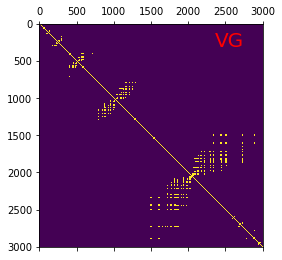

In [13]:
#生成邻接矩阵
def matrix_z(Q):
    arr=getVGPoint_z(Q)#调用不同方法，生成不同网络的邻接矩阵
    x=np.array(range(0,len(Q)))
    G = nx.Graph()# 无向图
    #G = nx.DiGraph()# 有向图
    #点
    G.add_nodes_from(x)  # 添加多个节点
    #边，将相连的两放进去
    for i in range(0,len(arr[0])):
        G.add_edges_from([(arr[0][i]+1,arr[1][i]+1)])
    #边，节点自连接
    for i in range(0,len(Q)):
        G.add_edges_from([(i+1,i+1)])
    
    # 画图的邻接矩阵
    matrix_arr=np.array(nx.adjacency_matrix(G).todense())
    #matrix_arr=nx.adjacency_matrix(G).todense()
    colors = ['while','yellow'] 
    cmap = mpl.colors.ListedColormap(colors)
    plt.matshow(np.transpose(matrix_arr))
    
    #图的一些设置
    #plt.xlabel('N',fontsize=20)
    #plt.ylabel('N',fontsize=20)
    plt.title('VG',fontsize=20,y=0.87,x=0.85,color='red')
    
    #保存图片
    #plt.savefig('',dpi=600)
    
    #plt.show()
    
    #return p1

#调用函数
matrix_z(conway(3000))

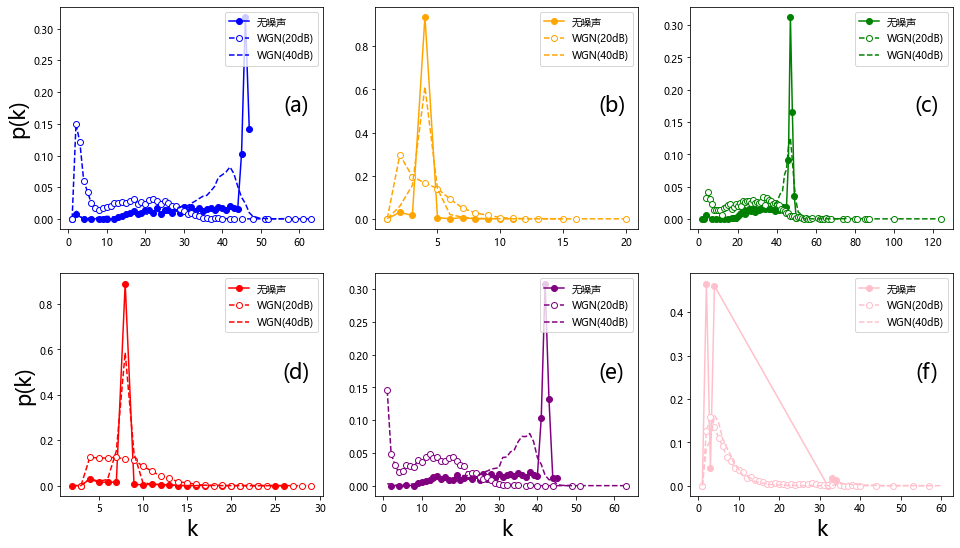

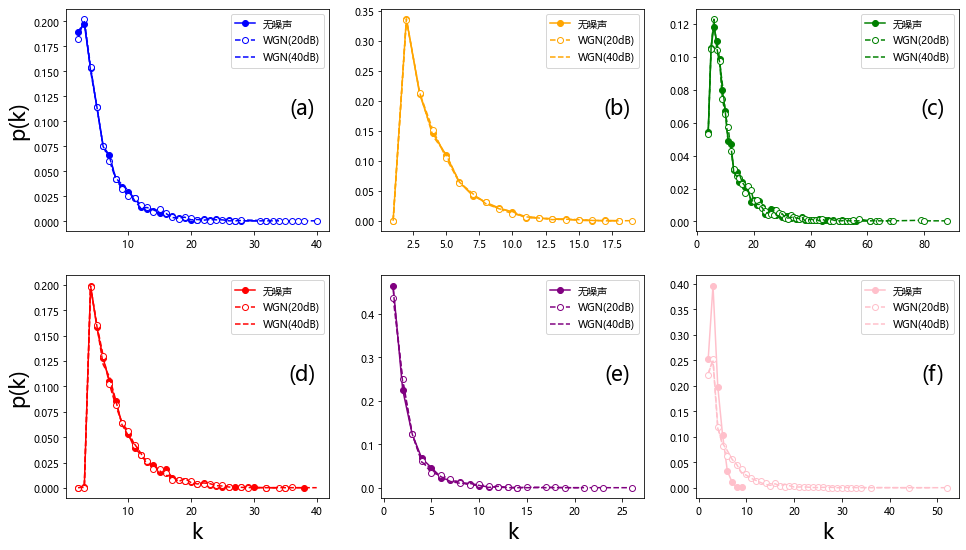

In [26]:
import matplotlib as mpl

#度分布图:输入序列和文件名，保存该序列的度分布图
def degree_plot(Q,picture_name):
    fig=plt.figure(figsize=(16,9))
    
    # 这两行代码解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    #plt.ylim(1e-5,1e1)
    #plt.xlim(2,60)
    
    
    #计算度分布图的横纵坐标
    arrVG=getVGPoint_z(Q)
    arrVG20=getVGPoint_z(Q+wgn(Q,20))
    arrVG40=getVGPoint_z(Q+wgn(Q,40))
    
    arrHVG=getHVGPoint_z(Q)
    arrHVG20=getHVGPoint_z(Q+wgn(Q,20))
    arrHVG40=getHVGPoint_z(Q+wgn(Q,40))
    
    arrLPHVG=getLPHVGPoint_z(Q,1)
    arrLPHVG20=getLPHVGPoint_z(Q+wgn(Q,20),1)
    arrLPHVG40=getLPHVGPoint_z(Q+wgn(Q,40),1)
    
    arrLPVG=getLPVGPoint_z(Q,1)
    arrLPVG20=getLPVGPoint_z(Q+wgn(Q,20),1)
    arrLPVG40=getLPVGPoint_z(Q+wgn(Q,40),1)
    
    arrDVG=getDVGPoint(Q)
    arrDVG20=getDVGPoint(Q+wgn(Q,20))
    arrDVG40=getDVGPoint(Q+wgn(Q,40))
    
    arrMBVG=getVGPoint_z(Markov(Q))
    arrMBVG20=getVGPoint_z(Markov(Q)+wgn(Markov(Q),20))
    arrMBVG40=getVGPoint_z(Markov(Q)+wgn(Markov(Q),40))
    
    #画图
    ax=plt.subplot(2,3,1)
    #plt.scatter(getXY(arrMBVG,Q)[0],getXY(arrMBVG,Q)[1],marker="+",s=100,color="brown",label='MBVG')
    plt.plot(getXY(arrVG,Q)[0],getXY(arrVG,Q)[1],color="blue",marker="o",label='无噪声')
    plt.plot(getXY(arrVG20,Q)[0],getXY(arrVG20,Q)[1],color='blue',marker="o",markerfacecolor='white',linestyle="--",label='WGN(20dB)')
    plt.plot(getXY(arrVG40,Q)[0],getXY(arrVG40,Q)[1],color='blue' ,linestyle="--",label='WGN(40dB)')
    plt.title('(a)',x=0.9,y=0.5,fontsize=21)
    #plt.xlabel('k',fontsize=15)
    plt.ylabel('p(k)',fontsize=21)
    plt.legend(loc='upper right')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(2,500)
#     plt.xlim(0,125)
    #length=len(getXY(arrVG,Q)[0])
    #lastx=getXY(arrVG,Q)[0][length-1]
    #lasty2=getXY(arrVG,Q)[1][length-1]
    #plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='blue', linewidth=1)
    #plt.text(lastx-2.3,-0.045,int(lastx),fontdict={'size':'11','color':'blue'})
    
    ax=plt.subplot(2,3,2)
    plt.plot(getXY(arrHVG,Q)[0],getXY(arrHVG,Q)[1],color="orange",marker="o",label='无噪声')
    plt.plot(getXY(arrHVG20,Q)[0],getXY(arrHVG20,Q)[1],color='orange',marker="o",markerfacecolor='white',linestyle="--",label='WGN(20dB)')
    plt.plot(getXY(arrHVG40,Q)[0],getXY(arrHVG40,Q)[1],color='orange' ,linestyle="--",label='WGN(40dB)')
    plt.title('(b)',x=0.9,y=0.5,fontsize=21)
    #plt.xlabel('k',fontsize=15)
    #plt.ylabel('p(k)',fontsize=15)
    plt.legend(loc='upper right')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(2,30)
    
    ax=plt.subplot(2,3,3)
    plt.plot(getXY(arrLPVG,Q)[0],getXY(arrLPVG,Q)[1],color="green",marker="o",label='无噪声')
    plt.plot(getXY(arrLPVG20,Q)[0],getXY(arrLPVG20,Q)[1],color='green',marker="o",markerfacecolor='white',linestyle="--",label='WGN(20dB)')
    plt.plot(getXY(arrLPVG40,Q)[0],getXY(arrLPVG40,Q)[1],color='green' ,linestyle="--",label='WGN(40dB)')
    plt.title('(c)',x=0.9,y=0.5,fontsize=21)
    #plt.xlabel('k',fontsize=15)
#     plt.ylabel('p(k)',fontsize=21)
    plt.legend(loc='upper right')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(4,500)
#     plt.xlim(0,125)
    
    ax=plt.subplot(2,3,4)
    plt.plot(getXY(arrLPHVG,Q)[0],getXY(arrLPHVG,Q)[1],color="red",marker="o",label='无噪声')
    plt.plot(getXY(arrLPHVG20,Q)[0],getXY(arrLPHVG20,Q)[1],color='red',marker="o",markerfacecolor='white',linestyle="--",label='WGN(20dB)')
    plt.plot(getXY(arrLPHVG40,Q)[0],getXY(arrLPHVG40,Q)[1],color='red' ,linestyle="--",label='WGN(40dB)')
    plt.title('(d)',x=0.9,y=0.5,fontsize=21)
    plt.xlabel('k',fontsize=21)
    plt.ylabel('p(k)',fontsize=21)
    plt.legend(loc='upper right')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(2,50)
    
    ax=plt.subplot(2,3,5)
    plt.plot(getXY(arrDVG,Q)[0],getXY(arrDVG,Q)[1],color="purple",marker="o",label='无噪声')
    plt.plot(getXY(arrDVG20,Q)[0],getXY(arrDVG20,Q)[1],color='purple',marker="o",markerfacecolor='white',linestyle="--",label='WGN(20dB)')
    plt.plot(getXY(arrDVG40,Q)[0],getXY(arrDVG40,Q)[1],color='purple' ,linestyle="--",label='WGN(40dB)')
    plt.title('(e)',x=0.9,y=0.5,fontsize=21)
    plt.xlabel('k',fontsize=21)
#     plt.ylabel('p(k)',fontsize=21)
    plt.legend(loc='upper right')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(2,500)
#     plt.xlim(0,105)
    
    ax=plt.subplot(2,3,6)
    plt.plot(getXY(arrMBVG,Q)[0],getXY(arrMBVG,Q)[1],color="pink",marker="o",label='无噪声')
    plt.plot(getXY(arrMBVG20,Q)[0],getXY(arrMBVG20,Q)[1],color='pink',marker="o",markerfacecolor='white',linestyle="--",label='WGN(20dB)')
    plt.plot(getXY(arrMBVG40,Q)[0],getXY(arrMBVG40,Q)[1],color='pink' ,linestyle="--",label='WGN(40dB)')
    plt.title('(f)',x=0.9,y=0.5,fontsize=21)
    plt.xlabel('k',fontsize=21)
    #plt.ylabel('p(k)',fontsize=15)
    plt.legend(loc='upper right')
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xlim(2,60)
    
    #图的一些设置
    #plt.title('',y=1.03)
#     plt.xlabel('k',fontsize=15)
#     plt.ylabel('p(k)',fontsize=15)
#     plt.legend()# 显示图例，即每条线对应 label 中的内容
    
    #保存图片
    plt.savefig(picture_name,dpi=600,bbox_inches='tight')
    
    #显示图表
    plt.show()

# degree_plot(conway(3000),'Conway加噪信号度分布图.png')
degree_plot(sin(3000),'sin加噪信号度分布图.png')
# degree_plot(track2[:,2][:3000],'lorenz加噪信号度分布图.png')
degree_plot(random(3000),'随机加噪信号度分布图.png')

In [16]:
#入度度分布图
def degree_plot(Q):
    # 这两行代码解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    plt.ylim(-0.05,0.8)
    #plt.xlim(1e0,1e2)
    #plt.xscale('log')
    #plt.yscale('log')
    
    #数据
    arrDHVG=getHVGPoint_z(Q)
    arrPNVG=getPNVGPoint_z(Q,math.pi/2)
    arrDLPVG=getLPVGPoint_z(Q,1)
        
    #画图(入度)
    #print(getXY2(arrDHVG,Q)[0])
    #print(getXY2(arrDHVG,Q)[1])
    plt.plot(getXY2(arrDHVG,Q)[0][0],getXY2(arrDHVG,Q)[0][1],linestyle ='-',color="blue",label='DHVG')
    length=len(getXY2(arrDHVG,Q)[0][0])
    lastx=getXY2(arrDHVG,Q)[0][0][length-1]
    lasty1=1e-4
    lasty2=getXY2(arrDHVG,Q)[0][1][length-1]
    plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='blue', linewidth=1)
    plt.text(lastx+0.1,-0.045,int(lastx),fontdict={'size':'11','color':'blue'})
    
    plt.plot(getXY2(arrPNVG,Q)[0][0],getXY2(arrPNVG,Q)[0][1],linestyle ='-',color="red",label='PNVG(α=90°)')
    length=len(getXY2(arrPNVG,Q)[0][0])
    lastx=getXY2(arrPNVG,Q)[0][0][length-1]
    lasty1=1e-4
    lasty2=getXY2(arrPNVG,Q)[0][1][length-1]
    plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='red', linewidth=1)
    plt.text(lastx+0.1,-0.045,int(lastx),fontdict={'size':'11','color':'red'})
    
    plt.plot(getXY2(arrDLPVG,Q)[0][0],getXY2(arrDLPVG,Q)[0][1],linestyle ='-',color="green",label='DLPVG(N=1)')
    length=len(getXY2(arrDLPVG,Q)[0][0])
    lastx=getXY2(arrDLPVG,Q)[0][0][length-1]
    lasty1=1e-4
    lasty2=getXY2(arrDLPVG,Q)[0][1][length-1]
    plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='green', linewidth=1)
    plt.text(lastx+0.1,-0.045,int(lastx),fontdict={'size':'11','color':'green'})
    
    #图的一些设置
    #plt.title('长度为300的随机序列',y=1.03)
    plt.xlabel('k',fontsize=15)
    plt.ylabel('p(k)',fontsize=15)
    plt.legend()# 显示图例，即每条线对应 label 中的内容
    
    #保存图片
    #plt.savefig('度分布图(入度)_随机300.png',dpi=600)
    
    #显示图表
    plt.show()
    
degree_plot(r)

NameError: name 'r' is not defined

<ipython-input-11-fb1668e01ec0>:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([[xin,yin],[xout,yout]])


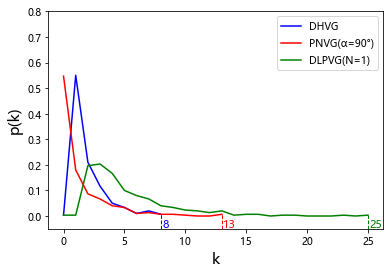

In [102]:
#出度度分布图
def degree_plot(Q):
    # 这两行代码解决 plt 中文显示的问题
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
    plt.rcParams['axes.unicode_minus'] = False
    plt.ylim(-0.05,0.8)
    #plt.xlim(-1,30)
    #plt.xlim(1e0,1e2)
    #plt.xscale('log')
    #plt.yscale('log')
    
    #数据
    arrDHVG=getHVGPoint_z(Q)
    arrPNVG=getPNVGPoint_z(Q,math.pi/2)
    arrDLPVG=getLPVGPoint_z(Q,1)
        
    #画图(出度)
    #print(getXY2(arrDHVG,Q)[1])
    #print(getXY2(arrPNVG,Q)[1])
    plt.plot(getXY2(arrDHVG,Q)[1][0],getXY2(arrDHVG,Q)[1][1],linestyle ='-',color="blue",label='DHVG')
    length=len(getXY2(arrDHVG,Q)[1][0])
    lastx=getXY2(arrDHVG,Q)[1][0][length-1]
    lasty1=1e-4
    lasty2=getXY2(arrDHVG,Q)[1][1][length-1]
    plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='blue', linewidth=1)
    plt.text(lastx+0.1,-0.045,int(lastx),fontdict={'size':'11','color':'blue'})
    
    plt.plot(getXY2(arrPNVG,Q)[1][0],getXY2(arrPNVG,Q)[1][1],linestyle ='-',color="red",label='PNVG(α=90°)')
    length=len(getXY2(arrPNVG,Q)[1][0])
    lastx=getXY2(arrPNVG,Q)[1][0][length-1]
    lasty1=1e-4
    lasty2=getXY2(arrPNVG,Q)[1][1][length-1]
    plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='red', linewidth=1)
    plt.text(lastx+0.1,-0.045,int(lastx),fontdict={'size':'11','color':'red'})
    
    plt.plot(getXY2(arrDLPVG,Q)[1][0],getXY2(arrDLPVG,Q)[1][1],linestyle ='-',color="green",label='DLPVG(N=1)')
    length=len(getXY2(arrDLPVG,Q)[1][0])
    lastx=getXY2(arrDLPVG,Q)[1][0][length-1]
    lasty1=1e-4
    lasty2=getXY2(arrDLPVG,Q)[1][1][length-1]
    plt.vlines(lastx, -0.05, lasty2, linestyles='dashed', colors='green', linewidth=1)
    plt.text(lastx+0.1,-0.045,int(lastx),fontdict={'size':'11','color':'green'})
    
    #图的一些设置
    #plt.title('长度为300的随机序列',y=1.03)
    plt.xlabel('k',fontsize=15)
    plt.ylabel('p(k)',fontsize=15)
    plt.legend()# 显示图例，即每条线对应 label 中的内容
    
    #保存图片
    #plt.savefig('度分布图(出度)_随机300.png',dpi=600)
    
    #显示图表
    plt.show()
    
degree_plot(r)

In [21]:
#数据
df=pd.read_csv('.\\10个一维数据集\\Wine.txt',sep=',',header=None)
Q=np.array(df[df[0]==1][1])

#网络属性
arr=getLPVGPoint_z(Q,1)
x=np.array(range(0,len(Q)))
G = nx.Graph()# 无多重边无向图
G.clear()
#点
G.add_nodes_from(x)
#边，将相连的两放进去
for i in range(0,len(arr[0])):
    G.add_edges_from([(arr[0][i],arr[1][i])])    

#平均集聚系数
print(round(nx.average_clustering(G),4))
#平均最短路径长度
print(nx.average_shortest_path_length(G))
#密度
print(nx.density(G))




0.7449
2.3074225599064873
0.18410286382232613


In [110]:
#数据
Q=track2[:,0]+wgn(track2[:,0],40)

#网络属性
arr=getVGPoint_z(Q)
x=np.array(range(0,len(Q)))
G = nx.Graph()# 无多重边无向图
G.clear()
#点
G.add_nodes_from(x)
#边，将相连的两放进去
for i in range(0,len(arr[0])):
    G.add_edges_from([(arr[0][i],arr[1][i])])    
#平均集聚系数
print('VG:')
print(round(nx.average_clustering(G),4))

#网络属性
arr=getHVGPoint_z(Q)
x=np.array(range(0,len(Q)))
G = nx.Graph()# 无多重边无向图
G.clear()
#点
G.add_nodes_from(x)
#边，将相连的两放进去
for i in range(0,len(arr[0])):
    G.add_edges_from([(arr[0][i],arr[1][i])])    
#平均集聚系数
print('HVG:')
print(round(nx.average_clustering(G),4))

#网络属性
arr=getLPVGPoint_z(Q,1)
x=np.array(range(0,len(Q)))
G = nx.Graph()# 无多重边无向图
G.clear()
#点
G.add_nodes_from(x)
#边，将相连的两放进去
for i in range(0,len(arr[0])):
    G.add_edges_from([(arr[0][i],arr[1][i])])    
#平均集聚系数
print('LPVG:')
print(round(nx.average_clustering(G),4))

#网络属性
arr=getLPHVGPoint_z(Q,1)
x=np.array(range(0,len(Q)))
G = nx.Graph()# 无多重边无向图
G.clear()
#点
G.add_nodes_from(x)
#边，将相连的两放进去
for i in range(0,len(arr[0])):
    G.add_edges_from([(arr[0][i],arr[1][i])])    
#平均集聚系数
print('LPHVG:')
print(round(nx.average_clustering(G),4))



VG:
0.558
HVG:
0.5621
LPVG:
0.6295
LPHVG:
0.6383
